Source notebook: https://github.com/statscol/clip-fine-tuning/blob/main/clip-fine-tuning.ipynb

## Fine-tuning Clip on PolyHaven dataset


The following graph shows the approach, where basically we need an image an text encoder to compute representations on each source and compute similarities later on

![image.png](https://miro.medium.com/max/786/1*tg7akErlMSyCLQxrMtQIYw.png)

In [1]:
import numpy as np
import clip
import torch
from tqdm.notebook import tqdm
from pkg_resources import packaging
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
print("Torch version:", torch.__version__)

Torch version: 2.0.1


## Load CLIP and VAE

In [2]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

from model import VAE
vae = VAE().to(DEVICE)

to_tensor = transforms.ToTensor()

vae_transform = transforms.Compose([
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

vae.load_state_dict(torch.load("train_results/model_weights_final.pth"))

dummy input shape  torch.Size([4096])


<All keys matched successfully>

In [3]:
torch.cuda.empty_cache()
model, preprocess = clip.load("ViT-B/32", jit=False)

In [4]:
preprocess_tensor = transforms.Compose([
        preprocess.transforms[0],
        preprocess.transforms[1],
        preprocess.transforms[4]
])

def apply_vae(img, model_vae, preprocess_fn):

    img_vae = model_vae(vae_transform(img))[0]
    return preprocess_fn(img_vae).detach()

## Load Data

In [5]:
## Get labels
from pathlib import Path
import pandas as pd
labels=pd.read_json("dataset/polyhaven.json")
labels.head()

,name,tags,categories,caption
0,abandoned_bakery_1k,"[abandoned, empty, industrial, windows, bare, ...","[natural light, artificial light, urban, indoo...","[abandoned, empty, industrial, windows, bare, ..."
1,abandoned_church_1k,"[tree, autumn, church, abandoned, leaves]","[outdoor, nature, morning-afternoon, partly cl...","[tree, autumn, church, abandoned, leaves, outd..."
2,abandoned_construction_1k,"[brick, pillar, warehouse, rubble, abandoned, ...","[indoor, urban, natural light, medium contrast...","[brick, pillar, warehouse, rubble, abandoned, ..."
3,abandoned_factory_canteen_01_1k,"[hall, abandoned, fluorescent, industrial, bac...","[indoor, urban, low contrast, natural light]","[hall, abandoned, fluorescent, industrial, bac..."
4,abandoned_factory_canteen_02_1k,"[hall, abandoned, industrial, boxes, backplates]","[indoor, urban, natural light, medium contrast]","[hall, abandoned, industrial, boxes, backplate..."


In [6]:
train = labels
train.sort_values(by="name", ascending=True, inplace=True)
print(train.shape)

(477, 4)


In [7]:
#using datasets.ImageFolder makes loading images and preprocessing easier
image_folder = datasets.ImageFolder("dataset/polyhaven_clip",transform=to_tensor) #before transform=preprocess

In [8]:
## Create datasets
class PolyHaven(Dataset):
    def __init__(self,captions,image_tensors):
        self.captions=captions
        self.images=image_tensors
        
    def __getitem__(self,idx):
        image_idx,_=self.images[idx]
        caption_idx=self.captions[idx]
        return {'image':image_idx,'caption': " ".join(caption_idx)}
        
    def __len__(self):
        return len(self.captions)
    
dataset = PolyHaven(train.caption.values.tolist(), image_folder)
len(dataset)

477

In [9]:
## create dataloaders
BATCH_SIZE  =  8
TEST_SPLIT  = .2
RANDOM_SEED = 128

dataset_size = train.shape[0]
indices = list(range(dataset_size))
split = int(np.floor(TEST_SPLIT * dataset_size))
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

tr_dl = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
ts_dl = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

In [10]:
import torch.nn as nn
import torch.optim as optim

N_EPOCHS = 500
loss_img = nn.CrossEntropyLoss()
loss_caption = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(tr_dl)*N_EPOCHS)

## Training code

In [11]:
import random
import re

def get_random_words(sentence):
    # Tokenize the sentence into words using regular expression
    words = re.findall(r'\b\w+\b', sentence)
    
    # Check if there are at least three words in the sentence
    if len(words) < 3:
        return None
    
    # Choose three random words from the list
    random_words = random.sample(words, 3)
    
    # Create a new string by joining the selected random words
    random_words_string = ' '.join(random_words)
    
    return random_words_string

In [12]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

vae.eval()
vae.requires_grad_(False)

model.to(DEVICE)


## to avoid problems with mixed precision, taken from here https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float()


def validate(test_dl, use_vae=False):
    model.eval()
    test_loss=0.0
    for data in tqdm(test_dl,desc="Evaluating in validation set"):
        if use_vae == True:
            img_batch=apply_vae(data['image'].to(DEVICE), vae, preprocess_tensor)
        else: 
            img_batch=preprocess_tensor(data['image'].to(DEVICE))        
        captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
        with torch.no_grad():
            logits_image, logits_caption = model(img_batch, captions_batch)
        labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
        total_loss = (loss_img(logits_image,labels) + loss_caption(logits_caption,labels))/2
        test_loss+=total_loss.item()
    
    test_total_loss=test_loss/len(test_dl)
    print(f"Validation Loss {test_total_loss:.3f}")
    return test_total_loss


def train_model(n_epochs,train_dataloader,checkpoint_path:str="./clip_checkpoints", use_vae=False, model_name="default"):
    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)
        
    print(f"Using {DEVICE} for training")
    best_score=9999999
    history={'train_loss':[],'val_loss':[]}
    for epoch in tqdm(range(n_epochs)):
        total_steps=0
        train_loss=0.0
        model.train()
        for step,data in enumerate(train_dataloader,1):
            
            optimizer.zero_grad()
            if use_vae == True:
                img_batch=apply_vae(data['image'].to(DEVICE), vae, preprocess_tensor)
            else: 
                img_batch=preprocess_tensor(data['image'].to(DEVICE))

            #words = [get_random_words(caption) for caption in data['caption']]
            captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
            with torch.cuda.amp.autocast():
                logits_image, logits_caption = model(img_batch, captions_batch)
            labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
            img_loss=loss_img(logits_image,labels)
            caption_loss=loss_caption(logits_caption,labels)
            total_loss = (img_loss+caption_loss)/2
            total_loss.backward()
            train_loss+=total_loss.item()
            convert_models_to_fp32(model)
            optimizer.step()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            total_steps+=1
            scheduler.step() ##per step scheduler
            if step%100==0:
                print(f"Epoch {epoch} step loss:{train_loss/total_steps}")
                print(f"Lr at step {step}: {optimizer.param_groups[0]['lr']:.5f}")
            
        history['train_loss'].append(train_loss/len(train_dataloader))
        val_metrics=validate(ts_dl, use_vae=use_vae)
        history['val_loss'].append(val_metrics)

        if epoch+1==n_epochs:
            print("TRAINING COMPLETE!")
            if os.path.exists(Path(checkpoint_path)/"clip_finetuned_{}.pt".format(model_name)):
                os.remove(Path(checkpoint_path)/"clip_finetuned_{}.pt".format(model_name))
            best_score=val_metrics
            torch.save(model.state_dict(), Path(checkpoint_path)/"clip_finetuned_{}.pt".format(model_name))
            
    return history
            


## Train on the PolyHaven Dataset

In [13]:
USE_VAE = False
MODEL_NAME = "polyhaven"
results=train_model(N_EPOCHS,tr_dl, use_vae=False, model_name=MODEL_NAME)

Using cuda:0 for training


  0%|          | 0/500 [00:00<?, ?it/s]

/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/c

Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.551


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.618


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.550


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.560


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.810


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.477


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.489


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.477


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.413


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.347


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.302


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.479


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.459


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.334


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.532


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.461


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.460


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.446


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.464


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.551


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.489


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.553


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.654


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.808


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.534


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.489


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.462


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.497


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.485


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.272


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.315


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.358


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.434


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.431


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.403


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.542


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.722


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.769


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.875


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.738


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.421


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.599


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.552


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.319


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.410


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.388


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.456


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.531


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.476


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.499


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.617


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.548


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.596


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.609


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.602


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.669


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.737


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.799


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.669


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.615


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.695


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.442


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.539


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.558


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.434


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.298


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.499


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.447


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.619


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.420


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.549


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.614


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.843


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.456


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.695


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.597


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.420


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.772


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.589


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.651


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.663


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.646


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.739


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.706


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.962


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.946


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.784


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.657


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.829


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.932


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.697


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.569


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.570


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.811


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.469


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.973


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.600


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.596


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.815


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.429


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.535


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.495


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.628


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.497


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.574


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.357


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.487


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.533


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.666


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.566


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.483


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.615


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.732


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.613


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.761


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.593


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.867


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.744


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.804


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.741


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.756


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.081


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.662


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.894


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.676


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.690


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.553


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.558


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.555


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.599


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.662


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.499


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.606


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.499


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.514


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.828


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.485


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.928


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.584


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.568


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.745


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.439


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.439


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.720


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.477


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.418


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.564


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.464


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.774


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.446


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.751


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.684


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.710


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.611


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.699


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.960


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.811


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.648


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.769


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.774


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.770


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.806


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.108


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.838


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.948


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.080


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.609


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.732


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.814


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.635


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.511


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.963


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.025


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.709


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.645


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.738


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.841


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.613


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.920


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.856


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.699


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.663


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.651


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.858


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.641


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.964


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.864


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.816


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.443


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.594


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.633


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.541


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.495


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.698


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.760


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.702


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.735


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.830


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.659


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.601


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.561


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.462


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.639


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.583


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.614


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.550


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.696


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.471


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.616


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.439


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.712


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.528


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.796


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.599


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.488


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.529


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.630


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.703


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.814


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.769


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.826


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.680


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.755


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.550


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.643


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.481


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.496


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.769


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.668


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.529


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.830


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.465


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.546


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.847


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.957


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.629


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.515


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.485


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.612


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.632


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.769


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.555


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.647


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.525


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.668


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.687


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.661


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.763


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.778


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.657


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.740


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.663


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.665


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.618


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.651


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.717


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.011


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.786


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.687


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.719


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.716


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.702


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.540


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.454


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.559


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.734


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.893


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.713


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.837


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.831


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.866


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.922


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.893


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.839


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.741


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.797


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.898


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.653


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.813


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.818


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.745


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.879


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.665


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.691


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.933


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.873


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.913


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.727


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.874


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.731


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.823


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.686


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.745


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.538


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.765


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.800


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.949


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.014


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.579


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.764


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.760


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.906


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.737


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.795


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.854


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.935


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.907


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.688


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.973


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.754


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.000


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.016


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.755


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.777


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.812


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.883


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.660


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.886


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.836


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.842


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.709


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.723


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.960


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.824


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.858


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.737


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.872


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.796


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.756


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.717


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.837


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.766


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.890


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.538


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.713


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.763


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.044


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.739


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.673


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.686


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.691


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.728


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.846


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.949


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.804


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.854


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.929


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.862


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.747


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.892


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.094


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.865


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.129


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.120


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.202


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.857


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.052


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.874


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.016


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.940


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.804


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.845


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.757


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.991


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.818


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.691


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.131


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.851


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.677


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.747


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.929


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.933


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.907


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.859


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.773


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.635


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.670


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.795


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.759


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.218


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.892


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.869


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.923


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.814


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.943


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.651


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.713


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.881


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.963


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.935


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.736


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.971


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.686


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.108


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.965


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.762


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.825


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.686


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.998


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.123


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.698


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.648


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.760


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.874


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.879


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.703


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.688


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.150


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.773


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.907


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.761


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.884


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.590


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.841


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.770


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.933


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.747


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.732


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.903


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.792


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.693


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.669


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.618


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.672


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.728


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.613


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.888


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.770


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.743


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.807


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.806


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.673


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.888


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.789


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.744


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.662


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.706


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.654


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.990


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.803


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.673


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.955


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.658


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.777


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.555


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.663


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.678


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.662


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.927


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.825


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.948


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.805


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.787


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.676


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.646


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.812


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.874


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.744


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.655


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.696


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.748


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.852


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.565


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.814


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.705


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.768


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.766


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.822


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.751


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.946


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.652


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.815


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.807


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.817


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.835


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.744


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.026


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.845


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.706


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.925


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.659


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.818


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.788


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.760


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.830


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.713


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.987


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.696


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.840


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.646


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.794


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.758


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.685


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.738


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.827


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.784


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.615


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.890


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.399


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 0.865
TRAINING COMPLETE!


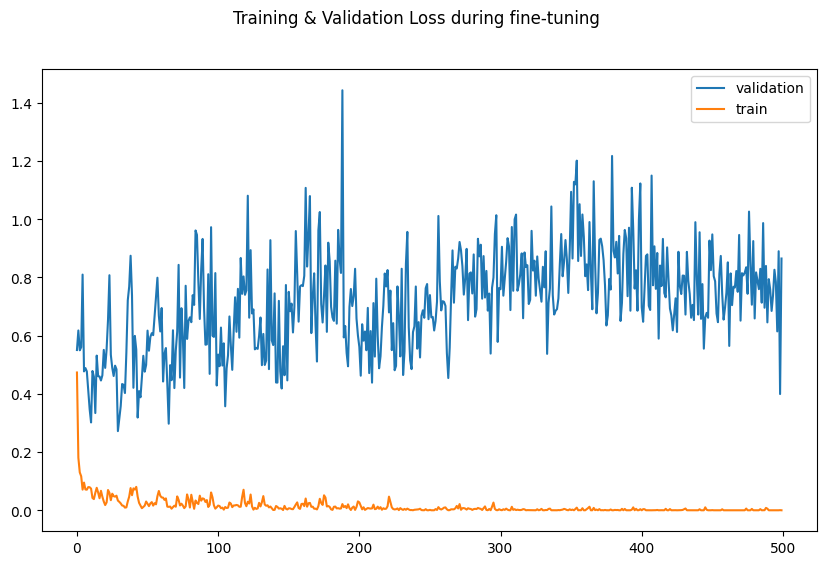

In [14]:
f,ax=plt.subplots(figsize=(10,6))
plt.plot(results['val_loss'],label="validation")
plt.plot(results['train_loss'],label="train")
plt.legend()
plt.suptitle("Training & Validation Loss during fine-tuning");

## Train on the VAE's output

In [15]:
USE_VAE = True
MODEL_NAME = "vae"
results=train_model(N_EPOCHS,tr_dl, use_vae=USE_VAE, model_name=MODEL_NAME)

Using cuda:0 for training


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.581


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.685


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.953


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.477


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.649


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.449


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.283


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.394


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.831


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.696


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.574


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.596


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.369


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.559


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.367


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.547


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.682


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.460


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.221


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.293


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.592


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.335


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.890


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.194


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.255


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.378


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.201


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.331


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.462


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.975


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.154


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.098


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.023


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.664


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.910


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.057


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.048


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.588


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.770


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.856


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.560


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.991


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.865


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.933


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.735


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.568


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.614


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.832


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.935


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.819


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.689


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.906


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.711


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.680


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.478


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.688


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.655


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.928


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.751


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.608


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.759


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.813


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.756


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.010


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.687


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.626


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.835


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.849


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.298


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.732


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.714


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.359


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.723


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.718


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.678


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.644


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.718


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.663


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.652


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.416


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.706


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.618


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.655


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.563


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.660


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.359


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.781


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.780


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.439


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.530


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.586


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.702


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.641


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.505


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.924


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.607


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.576


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.600


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.913


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.631


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.669


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.364


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.634


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.771


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.579


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.558


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.515


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.599


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.433


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.554


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.653


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.611


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.220


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.687


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.759


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.551


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.725


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.705


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.685


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.896


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.570


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.847


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.621


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.836


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.546


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.733


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.645


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.473


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.953


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.934


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.840


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.428


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.744


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.887


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.994


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.912


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.743


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.920


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.014


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.109


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.018


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.729


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.072


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.506


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.058


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.738


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.153


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.701


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.804


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.173


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.044


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.007


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.062


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.918


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.600


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.060


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.760


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.785


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.010


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.884


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.610


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.685


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.551


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.596


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.398


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.211


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.590


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.478


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.755


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.661


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.568


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.596


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.780


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.668


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.971


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.826


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.096


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.160


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.694


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.867


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.473


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.443


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.901


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.759


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.747


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.767


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.767


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.889


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.933


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.762


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.568


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.916


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.025


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.059


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.551


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.747


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.722


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.792


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.654


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.431


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.493


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.482


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.617


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.847


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.559


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.201


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.320


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.533


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.690


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.795


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.822


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.699


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.608


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.622


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.737


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.430


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.739


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.636


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.122


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.080


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.125


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.991


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.015


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.307


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.515


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.397


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.211


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.235


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.266


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.099


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.153


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.287


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.424


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.323


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.276


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.323


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.259


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.609


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.251


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.234


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.204


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.481


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.525


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.190


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.622


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.560


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.558


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.373


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.231


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.914


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.880


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.670


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.779


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.668


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.631


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.527


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.662


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.654


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.853


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.473


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.724


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.864


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.680


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.598


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.819


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.723


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.344


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.484


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.189


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.535


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.756


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.759


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.616


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.761


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.790


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.373


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.623


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.338


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.297


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.361


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.403


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.150


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.437


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.196


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.350


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.444


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.518


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.449


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.228


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.440


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.483


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.622


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.949


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.518


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.635


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.677


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.466


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.307


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.431


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.446


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.429


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.619


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.453


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.690


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.801


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.914


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.564


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.706


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.624


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.541


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.662


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.241


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.605


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.319


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.236


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.449


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.983


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.695


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.032


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.575


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.760


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.986


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.866


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.864


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.049


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.749


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.076


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.135


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.062


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.703


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.045


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.910


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.642


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.931


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.751


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.955


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.703


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.584


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.806


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.429


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.521


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.325


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.218


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.635


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.763


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.160


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.292


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.589


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.469


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.323


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.278


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.387


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.677


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.539


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.469


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.736


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.767


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.243


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.445


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.518


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.542


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.318


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.100


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.458


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.954


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.594


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.643


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.754


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.686


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.804


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.807


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.534


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.531


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.661


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.552


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.551


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.264


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.477


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.307


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.562


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.688


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.349


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.390


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.408


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.544


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.825


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.413


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.270


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.421


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.355


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.221


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.688


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.773


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.868


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.522


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.717


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.494


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.888


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.410


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.628


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.743


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.655


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.766


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.508


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.667


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.807


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.771


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.051


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.797


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.783


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.740


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.462


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.484


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.421


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.348


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.435


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.780


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.737


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.922


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.715


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.176


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.631


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.158


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.747


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.065


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.065


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.960


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.985


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.769


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.854


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.704


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.736


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.527


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.789


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.966


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.563


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.060


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.631


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.718


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.693


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.760


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.564


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.594


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.699


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.751


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.802


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.640


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.760


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.108


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.841


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.976


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.929


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.591


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.998


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.106


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.049


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.847


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.280


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.698


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.865


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.772


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.723


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.833


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.890


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.850


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.869


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.028


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.553


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.559


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.839


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.637


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.517


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.808


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.204


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.410


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.632


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.877


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.631


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.485


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.792


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.349


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.560


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.921


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.659


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.982


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.719


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.360


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.017


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.558


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.465


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.790


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.650


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 2.091


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.774


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.587


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.968


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.688


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.585


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.927


Evaluating in validation set:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss 1.929
TRAINING COMPLETE!


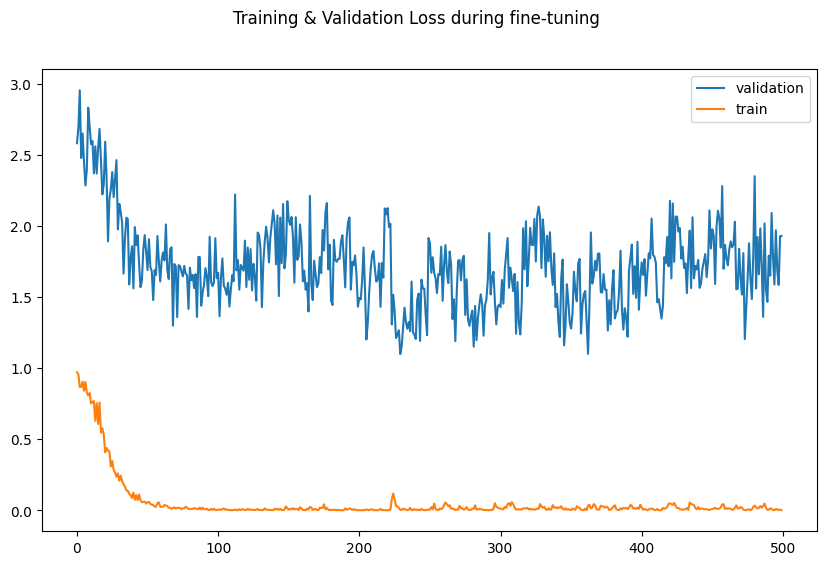

In [16]:
f,ax=plt.subplots(figsize=(10,6))
plt.plot(results['val_loss'],label="validation")
plt.plot(results['train_loss'],label="train")
plt.legend()
plt.suptitle("Training & Validation Loss during fine-tuning");